#Twitter US Airline Sentiment

https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27


https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [2]:
!pip3 install emoji

     |████████████████████████████████| 170 kB 4.5 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=025a60fcc98ece2ea062fcf0db9acdb84f87fe40e5fd5c0d0b99dc0efd52f147
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [3]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
# from sklearn.externals import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)
import nltk
nltk.download('stopwords')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Loading the dataset

In [7]:
df=pd.read_csv('Tweets.csv')

In [8]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [9]:
df=df.reindex(np.random.permutation(df.index))
df=df[['text','airline_sentiment']]

type(df)

pandas.core.frame.DataFrame

In [10]:
df

,text,airline_sentiment
2052,@united 1k member broken seat back broken tv broken light lost bag gee thnx. UA922 awesome job,negative
3804,@united please help! Left my iPad Air 2 on my flight from NYC to Paris yesterday and can’t get in touch with anyone locally. What to do?,neutral
645,@united A Tourist Wonder: Super Tides and Tide of the Century at French and U.K coasts: http://t.co/gXdqORtsS0,neutral
3409,@united @perfectomobile You really shouldn't use the word 'crashing.' Just sayin'.,neutral
5242,@SouthwestAir I just wanna say you're incredible for sending people to see their idols. Sooooo kind and amazing💖 #DestinationDragons,positive
...,...,...
4118,"@united Yesterday, I'm sorted now.",neutral
988,@united done,neutral
9036,"@USAirways I left my personal stuff on US4551 from PHL-BOS about an hour ago. Went baggage, was told plane left to call 800#",neutral
4459,"@SouthwestAir: Tried for VIP Live in The Vineyard but yr site went down, by the time I got in 2 redeem pts those packages gone.",negative


#EDA

In [39]:
# Unique values of sentiment
df['airline_sentiment'].unique()

array(['negative', 'neutral', 'positive'], dtype=object)

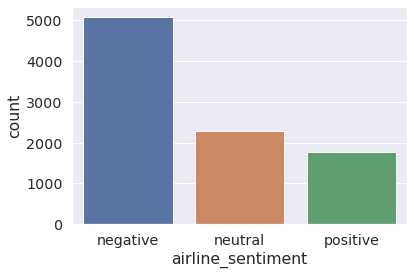

In [40]:
# Unique values of sentiment plot

ax = sns.countplot(x="airline_sentiment", data=df)

It is clearly observed from the above that the classes are imbalanced. We can visualize with the factorplotof the seaborn package

#Input Variables

In [12]:
df['text']

2052    @united 1k member broken seat back broken tv broken light lost bag  gee thnx. UA922 awesome job                                         
3804    @united please help! Left my iPad Air 2 on my flight from NYC to Paris yesterday and can’t get in touch with anyone locally. What to do?
645     @united A Tourist Wonder: Super Tides and Tide of the Century at French and U.K coasts: http://t.co/gXdqORtsS0                          
3409    @united @perfectomobile You really shouldn't use the word 'crashing.' Just sayin'.                                                      
5242    @SouthwestAir I just wanna say you're incredible for sending people to see their idols. Sooooo kind and amazing💖 #DestinationDragons    
                                                                        ...                                                                     
4118    @united Yesterday, I'm sorted now.                                                                                        

Let's analyse the text variable for that we create a class textcounts

In [13]:
class TextCounts(BaseEstimator,TransformerMixin):
  #It is a common function to count the regex
  def count_regex(self,pattern,tweet):
    return len(re.findall(pattern,tweet))
  
  #fit method is used when specific operations need to be done on the train data, but not on the test data
  # def fit(self,X,y=None,**fit_params):
  #   return self
  
  def transform(self,X,**transform_params):
    count_words=X.apply(lambda x:self.count_regex(r'\w+',x))
    count_mentions=X.apply(lambda x:self.count_regex(r'@\w+',x))
    count_hashtags=X.apply(lambda x:self.count_regex(r'#\w+',x))
    count_capital_words=X.apply(lambda x:self.count_regex(r'\b[A-Z]{2,}\b', x))
    count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
    count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
    count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))

    df=pd.DataFrame({'count_words':count_words,
                     'count_mentions':count_mentions,
                     'count_hashtags':count_hashtags,
                     'count_capital_words':count_capital_words,
                     'count_excl_quest_marks':count_excl_quest_marks,
                     'count_urls':count_urls,
                     'count_emojis':count_emojis})
    return df

tc=TextCounts()
df_eda=tc.fit_transform(df.text)
df_eda['airline_sentiment'] = df.airline_sentiment



In [38]:
df_eda

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,airline_sentiment,cleanText
2052,17,1,0,0,0,0,0,negative,nite member broken seat back broken tv broken light lost bag gee thnx ua awesom job
3804,28,1,0,1,2,0,0,neutral,nite pleas help left ipad air flight nyc pari yesterday can’t get touch anyon local
645,21,1,0,0,0,1,0,neutral,nite tourist wonder super tide tide centuri french coast
3409,12,2,0,0,0,0,0,neutral,nite erfectomobil realli use word crash sayin
5242,20,1,1,0,0,0,1,positive,outhwestair wanna say incred send peopl see idol sooooo kind amazing💖 destinationdragon
...,...,...,...,...,...,...,...,...,...
4118,6,1,0,0,0,0,0,neutral,nite yesterday sort
988,2,1,0,0,0,0,0,neutral,nite done
9036,24,1,0,2,0,0,0,neutral,sairway left person stuff us phl bo hour ago went baggag told plane left call
4459,25,1,0,1,0,0,0,negative,outhwestair tri vip live vineyard yr site went time got redeem pt packag gone


In [35]:
df.columns

Index(['text', 'airline_sentiment'], dtype='object')

#cleaning

In [14]:
class cleanText(BaseEstimator,TransformerMixin):
  def remove_mentions(self,input_text):
    return re.sub(r'@\w','',input_text)
  
  def remove_urls(self,input_text):
    return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
  
  def emoji_oneword(self, input_text):
    return input_text.replace('_','')

  def remove_punctuation(self, input_text):
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct)*' ')
    # Every punctuation symbol will be replaced by a space
    return input_text.translate(trantab)

  def remove_digits(self,input_text):
    return re.sub('\d+','',input_text)
  
  def to_lower(self,input_text):
    return input_text.lower()
  
  def remove_stopwords(self,input_text):
    stopwords_list = stopwords.words('english')
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 


  def stemming(self, input_text):
    porter = PorterStemmer()
    words = input_text.split() 
    stemmed_words = [porter.stem(word) for word in words]
    return " ".join(stemmed_words)


  def fit(self,X,y=None,**fit_params):
    return self
  
  def transform(self,X,**transform_params):
    clean_X=X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
    return clean_X

In [15]:
ct=cleanText()
sr_clean=ct.fit_transform(df.text)
sr_clean.head(5)

2052    nite member broken seat back broken tv broken light lost bag gee thnx ua awesom job    
3804    nite pleas help left ipad air flight nyc pari yesterday can’t get touch anyon local    
645     nite tourist wonder super tide tide centuri french coast                               
3409    nite erfectomobil realli use word crash sayin                                          
5242    outhwestair wanna say incred send peopl see idol sooooo kind amazing💖 destinationdragon
Name: text, dtype: object

#placeholder text

In [16]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

0 records have no words left after text cleaning


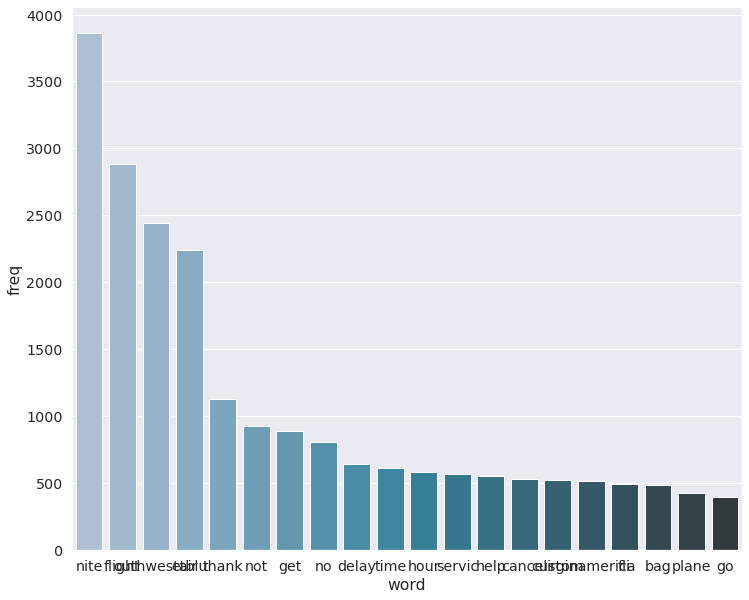

In [17]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

#Creating test data

In [66]:
df_model=df_eda
df_model['clean_text']=sr_clean
df_model.columns.to_list()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'airline_sentiment',
 'cleanText',
 'clean_text']

In [76]:
df_model.head(5)

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,airline_sentiment,cleanText,clean_text
2052,17,1,0,0,0,0,0,negative,nite member broken seat back broken tv broken light lost bag gee thnx ua awesom job,nite member broken seat back broken tv broken light lost bag gee thnx ua awesom job
3804,28,1,0,1,2,0,0,neutral,nite pleas help left ipad air flight nyc pari yesterday can’t get touch anyon local,nite pleas help left ipad air flight nyc pari yesterday can’t get touch anyon local
645,21,1,0,0,0,1,0,neutral,nite tourist wonder super tide tide centuri french coast,nite tourist wonder super tide tide centuri french coast
3409,12,2,0,0,0,0,0,neutral,nite erfectomobil realli use word crash sayin,nite erfectomobil realli use word crash sayin
5242,20,1,1,0,0,0,1,positive,outhwestair wanna say incred send peopl see idol sooooo kind amazing💖 destinationdragon,outhwestair wanna say incred send peopl see idol sooooo kind amazing💖 destinationdragon


In [68]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size=0.1, random_state=37)

In [ ]:
X_train

In [103]:
def grid_vect(clf,parameters_clf,X_train,X_test,parameters_text=None,vect=None,is_w2v=False):
   textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags','count_mentions','count_urls','count_words']
   size=50
   if is_w2v:
      w2vcols=[]
      for i in range(size):
        w2vcols.append(i)
      features=FeatureUnion([('textcounts',ColumnExtractor(cols=textcountscols)),('w2v', ColumnExtractor(cols=w2vcols))], n_jobs=-1)
   else:
      features=FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols)), ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))] , n_jobs=-1)
    
      pipeline=Pipeline([('features',features),('clf',clf)])

    # Join the parameters dictionaries together
      parameters = dict()
      if parameters_text:
        parameters.update(parameters_text)
      parameters.update(parameters_clf)

      grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)

      print("Performing grid search...")
      print("pipeline:", [name for name, _ in pipeline.steps])
      print("parameters:")
      print(parameters)

      t0 = time()
      grid_search.fit(X_train, y_train)
      print("done in %0.3fs" % (time() - t0))
      print()
      print("Best CV score: %0.3f" % grid_search.best_score_)


      print("Best parameters set:")
      best_parameters = grid_search.best_estimator_.get_params()
      for param_name in sorted(parameters.keys()):
          print("\t%s: %r" % (param_name, best_parameters[param_name]))
          
      print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
      print("\n")

      
      print("Classification Report Test Data")
      print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                          
      return grid_search     


In [70]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}
# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}
# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}


In [71]:
mnb = MultinomialNB()
logreg = LogisticRegression()

#CountVectorizer

https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c

CountVectorizer is a great tool provided by the scikit-learn library in Python. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. This is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors (for using in further text analysis).

In [73]:
import joblib

In [75]:
countvect = CountVectorizer()

# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
joblib.dump(best_mnb_countvect, '/content/best_mnb_countvect.pkl')

# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
joblib.dump(best_logreg_countvect, '/content/best_logreg_countvect.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'features__pipe__vect__max_df': (0.25, 0.5, 0.75), 'features__pipe__vect__ngram_range': ((1, 1), (1, 2)), 'features__pipe__vect__min_df': (1, 2), 'clf__alpha': (0.25, 0.5, 0.75)}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
done in 42.247s

Best CV score: 0.757
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.750


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.78      0.88      0.83       497
     neutral       0.63      0.54      0.58       229
    positive       0.78      0.67      0.72       190

    accuracy                           0.75       916
   macro avg       0.73      0.70      0.71       916
weighted avg       0.74      0.75      0.74       916

Performing grid search...
pipeline: ['features', 

['/content/best_logreg_countvect.pkl']

#TF-IDF Vectorizer

https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a



In [82]:
tfidfvect = TfidfVectorizer()
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
joblib.dump(best_mnb_tfidf, '/content/best_mnb_tfidf.pkl')

# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
joblib.dump(best_logreg_tfidf, '/content/best_logreg_tfidf.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'features__pipe__vect__max_df': (0.25, 0.5, 0.75), 'features__pipe__vect__ngram_range': ((1, 1), (1, 2)), 'features__pipe__vect__min_df': (1, 2), 'clf__alpha': (0.25, 0.5, 0.75)}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
done in 43.674s

Best CV score: 0.736
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.711


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.71      0.93      0.81       497
     neutral       0.64      0.38      0.48       229
    positive       0.79      0.53      0.63       190

    accuracy                           0.71       916
   macro avg       0.71      0.61      0.64       916
weighted avg       0.71      0.71      0.69       916

Performing grid search...
pipeline: ['features'

['/content/best_logreg_tfidf.pkl']

#Word2Vec

In [84]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [92]:
SIZE = 50
X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))
model = gensim.models.Word2Vec(X_train.clean_text_wordlist, min_count=1, size=SIZE, window=5, workers=4)
model.most_similar('plane', topn=3)

[('still', 0.999826967716217),
 ('arriv', 0.999825656414032),
 ('time', 0.999823808670044)]

In [93]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result
X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

In [94]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)

# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

In [104]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)
joblib.dump(best_logreg_w2v, '/content/best_logreg_w2v.pkl')

['/content/best_logreg_w2v.pkl']

#Apply the best model on new tweets

In [106]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags','count_mentions','count_urls','count_words']
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols)), ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))], n_jobs=-1)
pipeline = Pipeline([('features', features), ('clf', LogisticRegression(C=1.0, penalty='l2'))])
best_model = pipeline.fit(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment)

# Applying on new positive tweets
new_positive_tweets = pd.Series(["Thank you @VirginAmerica for you amazing customer support team on Tuesday 11/28 at @EWRairport and returning my lost bag in less than 24h! #efficiencyiskey #virginamerica"
,"Love flying with you guys ask these years. Sad that this will be the last trip 😂 @VirginAmerica #LuxuryTravel"
,"Wow @VirginAmerica main cabin select is the way to fly!! This plane is nice and clean & I have tons of legroom! Wahoo! NYC bound! ✈️"])
df_counts_pos = tc.transform(new_positive_tweets)
df_clean_pos = ct.transform(new_positive_tweets)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos
best_model.predict(df_model_pos).tolist()

['positive', 'positive', 'positive']

In [107]:
# Applying on new negative tweets
new_negative_tweets = pd.Series(["@VirginAmerica shocked my initially with the service, but then went on to shock me further with no response to what my complaint was. #unacceptable @Delta @richardbranson"
,"@VirginAmerica this morning I was forced to repack a suitcase w a medical device because it was barely overweight - wasn't even given an option to pay extra. My spouses suitcase then burst at the seam with the added device and had to be taped shut. Awful experience so far!"
,"Board airplane home. Computer issue. Get off plane, traverse airport to gate on opp side. Get on new plane hour later. Plane too heavy. 8 volunteers get off plane. Ohhh the adventure of travel ✈️ @VirginAmerica"])
df_counts_neg = tc.transform(new_negative_tweets)
df_clean_neg = ct.transform(new_negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg
best_model.predict(df_model_neg).tolist()

['negative', 'negative', 'negative']